In [4]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from pathlib import Path
from astropy import constants as const
import functions as fn
import box
import halo
#plt.style.use('default')
import my_rc_params

In [5]:
zoom_path = fn.ZOOMS_PATH/'c112_MDRInt'
boxes = np.array([])
no_BHs = 5
is_verbose = True

In [6]:
def get_energy(shot, n, is_verbose):
    str_shot = str(shot).zfill(3)
    box_f = box.Box(zoom_path, str_shot)
    
    snap_path = zoom_path/f'snap_{str_shot}.hdf5'
    fof_path = zoom_path/f'fof_subhalo_tab_{str_shot}.hdf5'
    
    with h5py.File(snap_path) as snap, h5py.File(fof_path) as fof:
        box_f.mass_BH = np.array(snap.get('PartType5/BH_Mass'))
        box_f.coords_BH = np.array(snap.get('PartType5/Coordinates'))
        box_f.energy_inj = np.array(snap.get('PartType5/BH_CumEgyInjection_QM'))
        box_f.u_gas = np.array(snap.get('PartType0/InternalEnergy')) * box_f.mass_gas
        
        halo_pos = np.array(fof.get('Group/GroupPos'))
        halo_r200c = np.array(fof.get('Group/Group_R_Crit200'))
    
    if is_verbose:
        print('-----------------------')
        print(f'shot: {shot}, z={box_f.z}')
        
    halos = np.array([halo.Halo(halo_pos[i,:], r200c) for i, r200c in enumerate(halo_r200c)])
    
    #grab n most massive BHs
    ndx = np.where((box_f.mass_BH >= np.sort(box_f.mass_BH)[-n]))[0]
    
    if is_verbose:
        print(f'BHs: {ndx}')
        print(f'{box_f.mass_BH[ndx]}')
    #add up injected energy
    box_f.tot_e_inj = np.sum(box_f.energy_inj[ndx])
    
    #find closest halo pos to BHs
    mdx = np.array([], dtype=int)
    for i in ndx:
        disp = fn.nearest(box_f.coords_BH[i,:] - halo_pos, box_f.size)
        dist = np.sum(disp**2, axis=1)
        mdx = np.append(mdx, np.where((dist == np.amin(dist)))[0][0])
        
    if is_verbose:
        print(f'Halos: {mdx}')
    #add up thermal energy
    box_f.tot_u = 0
    for i in mdx:
        disp = fn.nearest(box_f.coords_gas - halos[i].pos, box_f.size)
        dist = np.sum(disp**2, axis=1)
        ldx = np.where((dist <= halos[i].r200c))[0]
        box_f.tot_u += np.sum(box_f.u_gas[ldx])
    
    return box_f

In [7]:
for shot in range(39, 100):
    boxes = np.append(boxes, get_energy(shot, no_BHs, is_verbose))

-----------------------
shot: 39, z=3.008131071630377
BHs: [ 0  2  5  6 10]
[9.4384933e-04 9.2865121e-05 1.5178905e-04 1.7862993e-03 2.6028167e-04]
Halos: [   0 1133    1    2    4]
-----------------------
shot: 40, z=2.951558797468137
BHs: [ 0  9 10 11 16]
[0.00094598 0.00016709 0.00179615 0.00027437 0.00010204]
Halos: [0 2 3 4 8]
-----------------------
shot: 41, z=2.8957850057274284
BHs: [ 0  8  9 10 15]
[0.0010285  0.00017386 0.00179881 0.00043738 0.00010879]
Halos: [0 2 3 4 8]
-----------------------
shot: 42, z=2.859040507202043
BHs: [ 0  9 10 11 16]
[0.00102871 0.00021234 0.00179885 0.00044797 0.00011214]
Halos: [0 2 3 4 8]
-----------------------
shot: 43, z=2.804572553516131
BHs: [ 2  8  9 10 14]
[0.00113616 0.00031993 0.00179922 0.0004646  0.00011796]
Halos: [0 2 3 4 8]
-----------------------
shot: 44, z=2.7508733810786152
BHs: [ 0  3 11 12 15]
[0.00117166 0.00047645 0.00034027 0.00197001 0.00011841]
Halos: [0 1 3 4 7]
-----------------------
shot: 45, z=2.6979321390209017
B

In [8]:
#convert from 10^10 h^-1 M_Sun (km s^-1)^2 to erg (= g cm^2 s^-2) 
cgs = ((10**13 * const.M_sun) / boxes[0].h * (10**5)**2).value
#cgs=1e-8
z = np.array([box_f.z for box_f in boxes])
tot_u = np.array([box_f.tot_u for box_f in boxes]) * cgs
tot_e_inj = np.array([box_f.tot_e_inj for box_f in boxes]) * cgs

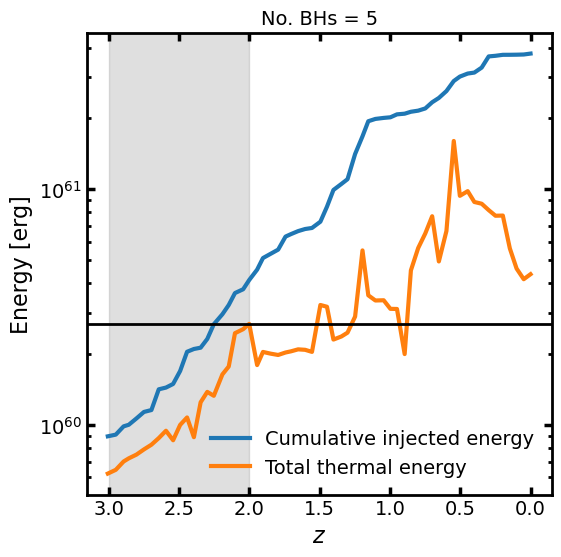

In [9]:
fg, ax = plt.subplots(figsize=(6,6))
ax.semilogy()
ax.set_xlabel(r'$z$')
ax.set_ylabel('Energy [erg]')
ax.set_title(f'No. BHs = {no_BHs}')
ax.invert_xaxis()
ax.plot(z, tot_e_inj, lw=3, label='Cumulative injected energy')
ax.plot(z, tot_u,lw=3, label='Total thermal energy')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvspan(3, 2, alpha=0.25, color='gray')
#ax.vlines(z[20], ylim[0], ylim[1], colors='k', zorder=10)
ax.hlines(tot_u[20], xlim[0], xlim[1], lw=2, colors='k', zorder=10)
ax.legend(loc='lower right')
fg.savefig(fn.HERE_PATH/f'Energy_Plot_n{no_BHs}.pdf', bbox_inches='tight')